In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from __future__ import print_function

import argparse, os, shutil, time, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F



bcl.py

In [ ]:
"""
Author: Yonglong Tian (yonglong@mit.edu)
Date: May 07, 2020
"""
from __future__ import print_function

import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import numpy as np



class BalSCL(nn.Module):
    def __init__(self, cls_num_list=None, temperature=0.1):
        super(BalSCL, self).__init__()
        self.temperature = temperature
        self.cls_num_list = cls_num_list

    def forward(self, centers1, features, targets, ):

        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))
        batch_size = features.shape[0]
        targets = targets.contiguous().view(-1, 1)
        targets_centers = torch.arange(len(self.cls_num_list), device=device).view(-1, 1)
        targets = torch.cat([targets.repeat(2, 1), targets_centers], dim=0)
        batch_cls_count = torch.eye(len(self.cls_num_list))[targets].sum(dim=0).squeeze()

        mask = torch.eq(targets[:2 * batch_size], targets.T).float().to(device)
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * 2).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # class-complement
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        features = torch.cat([features, centers1], dim=0)
        logits = features[:2 * batch_size].mm(features.T)
        logits = torch.div(logits, self.temperature)

        # For numerical stability
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()

        # class-averaging
        exp_logits = torch.exp(logits) * logits_mask
        per_ins_weight = torch.tensor([batch_cls_count[i] for i in targets], device=device).view(1, -1).expand(
            2 * batch_size, 2 * batch_size + len(self.cls_num_list)) - mask
        exp_logits_sum = exp_logits.div(per_ins_weight).sum(dim=1, keepdim=True)
        
        log_prob = logits - torch.log(exp_logits_sum)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        loss = - mean_log_prob_pos
        loss = loss.view(2, batch_size).mean()
        return loss




class LogitAdjust(nn.Module):

    def __init__(self, cls_num_list, tau=1, weight=None):
        super(LogitAdjust, self).__init__()
        cls_num_list = torch.cuda.FloatTensor(cls_num_list)
        cls_p_list = cls_num_list / cls_num_list.sum()
        m_list = tau * torch.log(cls_p_list)
        self.m_list = m_list.view(1, -1)
        self.weight = weight

    def forward(self, x, target):
        x_m = x + self.m_list
        return F.cross_entropy(x_m, target, weight=self.weight)


class BCLLoss(nn.Module):
    def __init__(self, cls_num_list, tau=1, weight=None, temperature = 0.1, alpha=2.0, beta=0.6 ):
        super(BCLLoss, self).__init__()
        self.criterion_ce = LogitAdjust(cls_num_list).cuda()
        self.criterion_scl = BalSCL(cls_num_list, temperature).cuda()
        self.alpha = alpha
        self.beta = beta
        
    def forward(self, centers,  logits, features, targets):
        scl_loss = self.criterion_scl(centers, features, targets)
        ce_loss = self.criterion_ce(logits, targets)

        return self.alpha * ce_loss + self.beta * scl_loss


        


bs.py

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class BS(nn.Module):
    def __init__(self, dist):
        super().__init__()
        dist = torch.from_numpy(np.array(dist)).float().cuda()
        self.prob = dist / sum(dist)
        self.log_prior = torch.log(self.prob).unsqueeze(0)
        
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        adjusted_logits = logits + self.log_prior
        return F.cross_entropy(adjusted_logits, targets, reduction = reduction)
        
        
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # logits = logits + torch.log(self.prob.view(1, -1).expand(logits.shape[0], -1)).cuda()
        
        # if reduction == 'none':
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

ce drw

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CE_DRW(nn.Module):
    
    def __init__(self, cls_num_list, reweight_epoch=160):
        super(CE_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch= reweight_epoch
        
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights

    def forward(self, x, target, epoch, reduction='mean'):
        self.drw(epoch)
        return F.cross_entropy(x, target, weight=self.weight, reduction=reduction)

ce

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CE(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    def forward(self, logits, targets, epoch=None, reduction='mean'):
        # targets = F.one_hot(targets, num_classes=logits.size(1))
        # if reduction == 'mean':
        #     return -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))
        # else:
        #     return -(torch.sum(F.log_softmax(logits, dim=1) * targets, dim=1))

        return F.cross_entropy(logits, targets, weight = self.weight, reduction = reduction)

ldam drw

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class LDAM_DRW(nn.Module):
    def __init__(self, cls_num_list, reweight_epoch, max_m=0.5, s=30):
        super(LDAM_DRW, self).__init__()
        self.cls_num_list = cls_num_list
        self.reweight_epoch = reweight_epoch
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
      
    def drw(self, epoch):
        idx = epoch // self.reweight_epoch
        betas = [0, 0.9999]
        effective_num = 1.0 - np.power(betas[idx], self.cls_num_list)
        per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
        per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(self.cls_num_list)
        per_cls_weights = torch.FloatTensor(per_cls_weights).cuda()
        self.weight = per_cls_weights


    def forward(self, x, target, epoch=None, reduction='mean'):
        self.drw(epoch)
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight, reduction=reduction)

ncl

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def NBOD(inputs, factor):

    classifier_num = len(inputs)
    if classifier_num == 1:
        return 0
    logits_softmax = []
    logits_logsoftmax = []
    for i in range(classifier_num):
        logits_softmax.append(F.softmax(inputs[i], dim=1))
        logits_logsoftmax.append(torch.log(logits_softmax[i] + 1e-9))

    loss_mutual = 0
    for i in range(classifier_num):
        for j in range(classifier_num):
            if i == j:
                continue
            loss_mutual += factor * F.kl_div(logits_logsoftmax[i], logits_softmax[j],reduction='batchmean')
    loss_mutual /= (classifier_num - 1)
    return  loss_mutual

class NIL_NBOD(nn.Module):
    def __init__(self, args, num_class_list):
        super(NIL_NBOD, self).__init__()
        self.args = args
        self.num_class_list = num_class_list
        self.bsce_weight = torch.FloatTensor(self.num_class_list).cuda()


        self.multi_classifier_diversity_factor = 0.6
        self.multi_classifier_diversity_factor_hcm = 0.6
        self.ce_ratio = 1.0
        self.hcm_ratio = 1.0
        if self.args.dataset == 'cifar100':
            self.hcm_N = 30
        elif self.args.dataset == 'imgnet':
            self.hcm_N = 300
        elif self.args.dataset == 'places':
            self.hcm_N = 122
        elif self.args.dataset == 'inat':
            self.hcm_N = 2442



    def forward(self, inputs, targets, **kwargs):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (classifier_num, batch_size, num_classes)
            targets: ground truth labels with shape (classifier_num, batch_size)
        """
        classifier_num = len(inputs)
        loss_HCM = 0
        loss = 0
        los_ce = 0

        inputs_HCM_balance = []
        inputs_balance = []
        class_select = inputs[0].scatter(1, targets[0].unsqueeze(1), 999999)
        class_select_include_target = class_select.sort(descending=True, dim=1)[1][:, :self.hcm_N]
        mask = torch.zeros_like(inputs[0]).scatter(1, class_select_include_target, 1)
        for i in range(classifier_num):

            logits = inputs[i] + self.bsce_weight.unsqueeze(0).expand(inputs[i].shape[0], -1).log()
            inputs_balance.append(logits)
            inputs_HCM_balance.append(logits * mask)

            los_ce += F.cross_entropy(logits, targets[0])
            loss_HCM += F.cross_entropy(inputs_HCM_balance[i], targets[0])

        loss += NBOD(inputs_balance, factor=self.multi_classifier_diversity_factor)
        loss += NBOD(inputs_HCM_balance, factor=self.multi_classifier_diversity_factor_hcm)
        loss += los_ce * self.ce_ratio + loss_HCM * self.hcm_ratio
        return loss

    def update(self, epoch):
        """
        Args:
           code can be added for progressive loss.
        """
        pass


if __name__ == '__main__':
    pass

ride

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random

class RIDE(nn.Module):
    def __init__(self, cls_num_list=None, base_diversity_temperature=1.0, max_m=0.5, s=30, reweight=True, reweight_epoch=-1, 
        base_loss_factor=1.0, additional_diversity_factor=-0.2, reweight_factor=0.05):
        super().__init__()
        self.base_loss = F.cross_entropy
        self.base_loss_factor = base_loss_factor
        if not reweight:
            self.reweight_epoch = -1
        else:
            self.reweight_epoch = reweight_epoch

        # LDAM is a variant of cross entropy and we handle it with self.m_list.
        if cls_num_list is None:
            # No cls_num_list is provided, then we cannot adjust cross entropy with LDAM.

            self.m_list = None
            self.per_cls_weights_enabled = None
            self.per_cls_weights_enabled_diversity = None
        else:
            # We will use LDAM loss if we provide cls_num_list.

            m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
            m_list = m_list * (max_m / np.max(m_list))
            m_list = torch.tensor(m_list, dtype=torch.float, requires_grad=False)
            self.m_list = m_list
            self.s = s
            assert s > 0
            
            if reweight_epoch != -1:
                idx = 1 # condition could be put in order to set idx
                betas = [0, 0.9999]
                effective_num = 1.0 - np.power(betas[idx], cls_num_list)
                per_cls_weights = (1.0 - betas[idx]) / np.array(effective_num)
                per_cls_weights = per_cls_weights / np.sum(per_cls_weights) * len(cls_num_list)
                self.per_cls_weights_enabled = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False)
            else:
                self.per_cls_weights_enabled = None

            cls_num_list = np.array(cls_num_list) / np.sum(cls_num_list)
            C = len(cls_num_list)
            per_cls_weights = C * cls_num_list * reweight_factor + 1 - reweight_factor

            # Experimental normalization: This is for easier hyperparam tuning, the effect can be described in the learning rate so the math formulation keeps the same.
            # At the same time, the 1 - max trick that was previously used is not required since weights are already adjusted.
            per_cls_weights = per_cls_weights / np.max(per_cls_weights)

            assert np.all(per_cls_weights > 0), "reweight factor is too large: out of bounds"
            # save diversity per_cls_weights
            self.per_cls_weights_enabled_diversity = torch.tensor(per_cls_weights, dtype=torch.float, requires_grad=False).cuda()

        self.base_diversity_temperature = base_diversity_temperature
        self.additional_diversity_factor = additional_diversity_factor

    def to(self, device):
        super().to(device)
        if self.m_list is not None:
            self.m_list = self.m_list.to(device)
        
        if self.per_cls_weights_enabled is not None:
            self.per_cls_weights_enabled = self.per_cls_weights_enabled.to(device)

        if self.per_cls_weights_enabled_diversity is not None:
            self.per_cls_weights_enabled_diversity = self.per_cls_weights_enabled_diversity.to(device)

        return self

    def _hook_before_epoch(self, epoch):
        if self.reweight_epoch != -1:
            self.epoch = epoch

            if epoch > self.reweight_epoch:
                self.per_cls_weights_base = self.per_cls_weights_enabled
                self.per_cls_weights_diversity = self.per_cls_weights_enabled_diversity
            else:
                self.per_cls_weights_base = None
                self.per_cls_weights_diversity = None

    def get_final_output(self, output_logits, target):
        x = output_logits

        index = torch.zeros_like(x, dtype=torch.uint8, device=x.device)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.float()
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m * self.s

        final_output = torch.where(index, x_m, x)
        return final_output

    def forward(self, output_logits, target, extra_info=None, reduction='mean'):
        if extra_info is None:
            return self.base_loss(output_logits, target)

        if reduction == 'none':
            loss = torch.zeros_like(target).float()
        else:
            loss = 0


        # Adding RIDE Individual Loss for each expert
        for logits_item in extra_info['logits']:
            ride_loss_logits = output_logits if self.additional_diversity_factor == 0 else logits_item
            if self.m_list is None:
                loss += self.base_loss_factor * self.base_loss(ride_loss_logits, target, reduction=reduction)
            else:
                final_output = self.get_final_output(ride_loss_logits, target)
                loss += self.base_loss_factor * self.base_loss(final_output, target, weight=self.per_cls_weights_base, reduction=reduction)
            
            base_diversity_temperature = self.base_diversity_temperature

            if self.per_cls_weights_diversity is not None:
                diversity_temperature = base_diversity_temperature * self.per_cls_weights_diversity.view((1, -1))
                temperature_mean = diversity_temperature.mean().item()
            else:
                diversity_temperature = base_diversity_temperature
                temperature_mean = base_diversity_temperature
            
            output_dist = F.log_softmax(logits_item / diversity_temperature, dim=1)
            with torch.no_grad():
                # Using the mean takes only linear instead of quadratic time in computing and has only a slight difference so using the mean is preferred here
                mean_output_dist = F.softmax(output_logits / diversity_temperature, dim=1)
            
            loss += self.additional_diversity_factor * temperature_mean * temperature_mean * F.kl_div(output_dist, mean_output_dist, reduction='batchmean')
        
        return loss

class RIDEWithDistill(nn.Module):
    def __init__(self, cls_num_list=None, additional_distill_loss_factor=1.0, distill_temperature=1.5, ride_loss_factor=1.0, **kwargs):
        super().__init__()
        self.ride_loss = RIDE(cls_num_list=cls_num_list, **kwargs)
        self.distill_temperature = distill_temperature

        self.ride_loss_factor = ride_loss_factor
        self.additional_distill_loss_factor = additional_distill_loss_factor

    def to(self, device):
        super().to(device)
        self.ride_loss = self.ride_loss.to(device)
        return self

    def _hook_before_epoch(self, epoch):
        self.ride_loss._hook_before_epoch(epoch)

    def forward(self, student, target=None, teacher=None, extra_info=None):
        output_logits = student
        if extra_info is None:
            return self.ride_loss(output_logits, target)

        loss = 0
        num_experts = len(extra_info['logits'])
        for logits_item in extra_info['logits']:
            loss += self.ride_loss_factor * self.ride_loss(output_logits, target, extra_info)
            distill_temperature = self.distill_temperature

            student_dist = F.log_softmax(student / distill_temperature, dim=1)
            with torch.no_grad():
                teacher_dist = F.softmax(teacher / distill_temperature, dim=1)
            
            distill_loss = F.kl_div(student_dist, teacher_dist, reduction='batchmean')
            distill_loss = distill_temperature * distill_temperature * distill_loss
            loss += self.additional_distill_loss_factor * distill_loss
        return loss

common.py


In [ ]:
from __future__ import print_function

import argparse, os, shutil, random, math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

!pip install progress
# added on my own
import progress 
#end

from progress.bar import Bar as Bar

def make_imb_data(max_num, class_num, gamma):
    mu = np.power(1/gamma, 1/(class_num - 1))
    class_num_list = []
    for i in range(class_num):
        if i == (class_num - 1):
            class_num_list.append(int(max_num / gamma))
        else:
            class_num_list.append(int(max_num * np.power(mu, i)))
    print(class_num_list)
    return list(class_num_list)

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def save_checkpoint(state, epoch, checkpoint='none', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    
    if epoch % 100 == 0:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_' + str(epoch) + '.pth.tar'))
        
def linear_rampup(current, rampup_length=0):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)
    
def adjust_learning_rate(optimizer, epoch, scheduler, args):
    if scheduler == None:
        if args.epochs == 200:
            epoch = epoch + 1
            if epoch <= args.warmup:
                lr = args.lr * epoch / args.warmup
            elif epoch > 180:
                lr = args.lr * args.lr_decay ** 2
            elif epoch > 160:
                lr = args.lr * args.lr_decay
            else:
                lr = args.lr

            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            return lr

        elif args.epochs == 400:
            if args.loss_fn == 'bcl':
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 380:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 360:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
            else:
                epoch = epoch + 1
                if epoch <= args.warmup:
                    lr = args.lr * epoch / args.warmup
                elif epoch > 360:
                    lr = args.lr * args.lr_decay ** 2
                elif epoch > 320:
                    lr = args.lr * args.lr_decay
                else:
                    lr = args.lr

                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                return lr
        else:
            return args.lr
    else:
        scheduler.step()
        return optimizer.param_groups[0]['lr']
    

loss.py

In [ ]:
import torch
import torch.optim as optim
from bisect import bisect_right



#from utils.common import adjust_learning_rate

from torch.optim import lr_scheduler

def get_optimizer(args, model):
    _model = model['model'] if args.loss_fn == 'ncl' else model
    return optim.SGD(_model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd,
                     nesterov=args.nesterov)

def get_scheduler(args, optimizer):
    if args.scheduler == 'cosine':
        return lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min = 0)
    elif args.scheduler == 'warmup':
        return None

def get_loss(args, N_SAMPLES_PER_CLASS):
    if args.loss_fn == 'ce':
        train_criterion = CE()
    elif args.loss_fn == 'ce_drw':
        train_criterion = CE_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160)
    elif args.loss_fn == 'bs':
        train_criterion = BS(N_SAMPLES_PER_CLASS)
    elif args.loss_fn == 'ldam_drw':
        train_criterion = LDAM_DRW(cls_num_list=N_SAMPLES_PER_CLASS, reweight_epoch=160, max_m=0.5, s=30).cuda()
    elif args.loss_fn == 'ride':
        if args.num_experts == 3 and args.ride_distill:
            train_criterion = RIDEWithDistill(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        else:
            train_criterion = RIDE(cls_num_list=N_SAMPLES_PER_CLASS, additional_diversity_factor=-0.45, reweight=True, reweight_epoch=160)
        train_criterion = train_criterion.to(torch.device('cuda'))
    elif args.loss_fn == 'ncl':
        train_criterion = NIL_NBOD(args, N_SAMPLES_PER_CLASS)

    elif args.loss_fn == 'bcl':
        train_criterion = BCLLoss(N_SAMPLES_PER_CLASS)

    else:
        raise NotImplementedError
        

    return train_criterion



cuda.py

In [ ]:
import torch as t
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.dataset import Dataset

import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image

def CUDA(img,m,n, rand=True, max_d=30):
    _augment_list = augment_list()
    ops = random.choices(_augment_list, k=n)
    m = float(m) / max_d
    for op, minval, maxval in ops:
        val = (float(m)) * float(maxval - minval) + minval
        img = op(img, val)
    return img

def Flip(img, _):
    return PIL.ImageOps.flip(img)

def Mirror(img, _):
    return PIL.ImageOps.mirror(img)

def EdgeEnhance(img, _):
    return img.filter(PIL.ImageFilter.EDGE_ENHANCE)

def Detail(img, _):
    return img.filter(PIL.ImageFilter.DETAIL)

def Smooth(img, _):
    return img.filter(PIL.ImageFilter.SMOOTH)
    
def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)

def Equalize(img, _):
    return PIL.ImageOps.equalize(img)

def Invert(img, _):
    return PIL.ImageOps.invert(img)

def GaussianBlur(img, v):
    # assert 0 <= v <= 5
    filter = PIL.ImageFilter.GaussianBlur(v)
    return img.filter(filter)

def ResizeCrop(img, v):
    # assert 1 <= v <= 2
    width, height = img.size
    enlarge = img.resize((int(width*v), int(height*v)), Image.ANTIALIAS)
    left = int(width*v)//2 - width//2
    right = int(width*v)//2 + width//2
    top = int(height*v)//2 - height//2
    bottom = int(height*v)//2 + height//2
    return enlarge.crop((left, top, right, bottom))

def Rotate(img, v):  # [-30, 30]
    # assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)

def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)

def Solarize(img, v):  # [0, 256]
    # assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)

def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)

def Color(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)

def Contrast(img, v):  # [0.1,1.9]ƒ
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)

def Brightness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)

def Sharpness(img, v):  # [0.1,1.9]
    # assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)

def ShearX(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))

def ShearY(img, v):  # [-0.3, 0.3]
    # assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))

def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))

def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    # assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

def augment_list():  
    l = [
        (Flip, 0, 1),
        (Mirror, 0, 1),
        (EdgeEnhance, 0, 1),
        (Detail, 0, 1),
        (Smooth, 0, 1),
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (GaussianBlur, 0, 2),
        (ResizeCrop,1, 1.5),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    

    return l



autoaug.py


In [ ]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random
import torch



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.
        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.
        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img

randaug.py


In [ ]:
# code in this file is adpated from rpmcruz/autoaugment
# https://github.com/rpmcruz/autoaugment/blob/master/transformations.py
import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)




def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    # color = (0, 0, 0)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # l = [
    #     (Identity, 0., 1.0),
    #     (ShearX, 0., 0.3),  # 0
    #     (ShearY, 0., 0.3),  # 1
    #     (TranslateX, 0., 0.33),  # 2
    #     (TranslateY, 0., 0.33),  # 3
    #     (Rotate, 0, 30),  # 4
    #     (AutoContrast, 0, 1),  # 5
    #     (Invert, 0, 1),  # 6
    #     (Equalize, 0, 1),  # 7
    #     (Solarize, 0, 110),  # 8
    #     (Posterize, 4, 8),  # 9
    #     # (Contrast, 0.1, 1.9),  # 10
    #     (Color, 0.1, 1.9),  # 11
    #     (Brightness, 0.1, 1.9),  # 12
    #     (Sharpness, 0.1, 1.9),  # 13
    #     # (Cutout, 0, 0.2),  # 14
    #     # (SamplePairing(imgs), 0, 0.4),  # 15
    # ]

    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
    ]

    return l


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = torch.Tensor(eigval)
        self.eigvec = torch.Tensor(eigvec)

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class CutoutDefault(object):
    """
    Reference : https://github.com/quark0/darts/blob/master/cnn/utils.py
    """
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img



cutout.py

In [ ]:
import torch
import numpy as np



class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    

transformer.py

In [ ]:
from torchvision.transforms import transforms
from PIL import ImageFilter
import random
#from aug.cutout import *

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)



class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x



def get_transform(loss_fn, cutout = False):
    # Augmentations.
    if loss_fn in ['ce', 'ldam_drw', 'bs', 'ce_drw', 'ride']:
        train_before = [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
            ]
        
        if cutout:
            train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]

        transform_train = [[transforms.Compose(train_before), transforms.Compose(train_after)]]

    elif loss_fn in ['ncl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]


        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]
        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]


    
    elif loss_fn in ['bcl']:
        regular_train_before = [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            ]

        if cutout:
            regular_train_after = [
                transforms.ToTensor(),
                Cutout(n_holes = 1, length = 16),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        else:
            regular_train_after = [
                transforms.ToTensor(),
                transforms.Normalize(cifar10_mean, cifar10_std),
                ]
        
        sim_cifar_before = [
            transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
            ]
        sim_cifar_after = [
            transforms.ToTensor(),
            transforms.Normalize(cifar10_mean, cifar10_std),
            ]

        transform_train = [
            [transforms.Compose(regular_train_before), 
            transforms.Compose(regular_train_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)], 
            [transforms.Compose(sim_cifar_before), 
            transforms.Compose(sim_cifar_after)],
            ]

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])
    
    return transform_train, transform_val
    





cifar100.py


In [ ]:
import numpy as np
from PIL import Image
import random

import torchvision
import torch

from torch.utils.data import Dataset

from torchvision.transforms import transforms



    
def get_cifar100(root, args):
    transform_train, transform_val = get_transform(args.loss_fn, cutout = args.cutout)

    train_dataset = CIFAR100_train(root, args, imb_ratio = args.imb_ratio, train=True, transform = transform_train, aug_prob=args.aug_prob)
    test_dataset = CIFAR100_val(root, transform=transform_val)
    print (f"#Train: {len(train_dataset)}, #Test: {len(test_dataset)}")
    return train_dataset, test_dataset
    
class test_CIFAR100(Dataset):
    def __init__(self, indices, state, cifar_dataset):
        self.indices = indices
        self.state = state
        self.dataset = cifar_dataset

    def __getitem__(self,idx):
        data, label, _ = self.dataset.get_item(self.indices[idx], self.state[idx], train=False)
        return data, label, self.indices[idx], self.state[idx]
    
    def __len__(self):
        return len(self.indices)

class CIFAR100_train(torchvision.datasets.CIFAR100):
    def __init__(self, root , args, aug_prob, imb_type='exp', imb_ratio=100, train=True, transform=None, target_transform=None, download=True):
        super(CIFAR100_train,self).__init__(root, train=train, transform=transform, target_transform = target_transform, download= download)

        np.random.seed(0)
        self.args = args
        self.cls_num = 100
        self.img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, 1./imb_ratio)
        self.transform_train = transform
        self.gen_imbalanced_data(self.img_num_list)
        

        if 'autoaug_cifar' in args.aug_type:
            print('autoaug_cifar')
            self.aug_transform = transforms.Compose([CIFAR10Policy()])
        elif 'autoaug_svhn' in args.aug_type:
            print('autoaug_svhn')
            self.aug_transform = transforms.Compose([SVHNPolicy()])
        elif 'autoaug_imagenet' in args.aug_type:
            print('autoaug_imagenet')
            self.aug_transform = transforms.Compose([ImageNetPolicy()])
        #elif 'dada_cifar' in args.aug_type:
            print('dada_cifar')
            self.aug_transform = transforms.Compose([dada_cifar()])
        #elif 'dada_imagenet' in args.aug_type:
            print('dada_imagenet')
            self.aug_transform = transforms.Compose([dada_imagenet()])
        #elif 'faa_cifar' in args.aug_type:
            print('faa_cifar')
            self.aug_transform = transforms.Compose([faa_cifar()])
        #elif 'faa_imagenet' in args.aug_type:
            print('faa_imagenet')
            self.aug_transform = transforms.Compose([faa_imagenet()])
        elif 'randaug' in args.aug_type:
            print('randaug')
            self.aug_transform = transforms.Compose([RandAugment(2, 14)])
        elif 'none' in args.aug_type:
            self.aug_transform = transforms.Compose([])
        else:
            raise NotImplementedError
        



        # max_mag = 10
        # max_ops = 10
        max_mag = 10
        max_ops = 10
        self.min_state = 0
        self.max_state = max(max_mag, max_ops) + 1
        
        states = torch.arange(self.min_state, self.max_state)
        if self.max_state == 1:
            self.ops = torch.tensor([0])
            self.mag = torch.tensor([0])
            
        elif max_mag > max_ops:
            self.ops = (states * max_ops / max_mag).ceil().int()
            self.mag = states.int()
        else:
            self.mag = (states * max_mag / max_ops).ceil().int()
            self.ops = states.int()
        
        print(f"Magnitude set = {self.mag}")
        print(f"Operation set = {self.ops}")

        self.curr_state = torch.zeros(len(self.data))
        self.score_tmp = torch.zeros((len(self.targets), self.max_state))
        self.num_test = torch.zeros((len(self.targets), self.max_state))
        self.aug_prob = aug_prob



    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor ** (cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls


    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        #changed from np.int64
        targets_np = np.array(self.targets, dtype=int)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)

        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            # print(selec_idx)
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets

    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

    def sim_aug(self, img, state, type):
        if type == 'cuda':
            return  CUDA(img, self.mag[state], self.ops[state], max_d = self.args.max_d)
        else:
            return img
        

    
    def get_item(self, index, state, train=True):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        if train:
            if len(self.transform_train) == 1:
                img = self.transform_train[0][0](img)
                img = self.aug_transform(img)
                img = CUDA(img, self.mag[state], self.ops[state])
                img = self.transform_train[0][1](img)
                return img, target, index

            elif len(self.transform_train) == 2:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                return (img1, img2), target, index
                
            elif len(self.transform_train) == 3:
                img1 = self.transform_train[0][0](img)
                img1 = self.aug_transform(img1)
                img1 = CUDA(img1, self.mag[state], self.ops[state], max_d = self.args.max_d)
                img1 = self.transform_train[0][1](img1)

                img2 = self.transform_train[1][0](img)
                img2 = self.sim_aug(img2, state, self.args.sim_type)
                img2 = self.transform_train[1][1](img2)
                
                img3 = self.transform_train[2][0](img)
                img3 = self.sim_aug(img3, state, self.args.sim_type)
                img3 = self.transform_train[2][1](img3)
                return (img1, img2, img3), target, index

        else:
            img = self.transform_train[0][0](img)
            img = self.aug_transform(img)
            img = CUDA(img, self.mag[state], self.ops[state], rand=False , max_d = self.args.max_d)
            img = self.transform_train[0][1](img)
            return img, target, index
        
    def __getitem__(self, index):
        state = self.curr_state[index].int() if torch.rand(1) < self.aug_prob else 0
        
        img, target, index = self.get_item(index, state, train=True)
        return img, target, index
    
    def update_scores(self, correct, index, state):
        for s in np.unique(state):
            pos = np.where(state == s)
            score_result = np.bincount(index[pos], correct[pos], len(self.score_tmp))
            num_test_result = np.bincount(index[pos], np.ones(len(index))[pos], len(self.score_tmp))
            self.score_tmp[:,s] += score_result
            self.num_test[:,s] += num_test_result
            

    def update(self):
        # Increase
        pos = torch.where((self.score_tmp == self.num_test) & (self.num_test != 0))
        self.curr_state[pos] += 1
        
        # Decrease
        pos = torch.where(self.score_tmp != self.num_test)
        self.curr_state[pos] -= 1
        
        
        self.curr_state = torch.clamp(self.curr_state, self.min_state, self.max_state-1)
        self.score_tmp *= 0
        self.num_test *= 0
        
    
class CIFAR100_val(torchvision.datasets.CIFAR100):
    def __init__(self, root, transform=None, indexs=None,
                 target_transform=None, download=True):
        super(CIFAR100_val, self).__init__(root, train=False, transform=transform, target_transform=target_transform,download=download)
        
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
        self.data = [Image.fromarray(img) for img in self.data]
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, index

accuracy.py

In [ ]:
from __future__ import print_function, absolute_import

import errno
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable


__all__ = ['accuracy', 'AverageMeter']

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

cutmix.py

In [ ]:
import torch
import numpy as np

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data_f, data_b):
    lam = np.random.beta(1., 1.)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data_f.size(), lam)
    data_b[:, :, bbx1:bbx2, bby1:bby2] = data_f[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1-((bbx2 - bbx1) * (bby2 - bby1) / (data_f.size()[2] * data_f.size()[3]))
    
    return data_b, torch.tensor(lam)

# def cutmix(data_aug, data, label, param, percent=1.0):
    # data = data_aug
    # sample_num = int(len(param)*percent)
    # argsort = torch.argsort(param,descending=True)
    # param /= torch.max(param)
    
    # candidate = argsort[:sample_num]
    
    # data_f = data[candidate]
    # label_f = label[candidate]
    # param_f = param[candidate]
    
    # back_perm = candidate[torch.randperm(len(candidate))]
    # data_b = data[back_perm]
    # label_b = label[back_perm]
    # param_b = param[back_perm]
    
    # # lam = torch.exp(param_f) / (torch.exp(param_f)+torch.exp(param_b))
    # lam = torch.tensor(np.random.beta(1.,1.,(sample_num,)))
    
    # size = data.size()
    # W = size[2]
    # H = size[3]
    # cut_rat = torch.sqrt(1. - lam)
    # cut_w = (cut_rat * W).int()
    # cut_h = (cut_rat * H).int()

    # # uniform
    # cx = torch.randint(0,W,(len(candidate),))
    # cy = torch.randint(0,H,(len(candidate),))

    # bbx1 = torch.clip(cx - cut_w // 2, 0, W)
    # bby1 = torch.clip(cy - cut_h // 2, 0, H)
    # bbx2 = torch.clip(cx + cut_w // 2, 0, W)
    # bby2 = torch.clip(cy + cut_h // 2, 0, H)
    
    # for idx in range(len(data_b)):
    #     data_b[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]] = data_f[idx, :, bbx1[idx]:bbx2[idx], bby1[idx]:bby2[idx]]
    # data_aug[candidate] = data_b
    
    # label[candidate] = label_b
    # label_aug = torch.zeros(len(label),dtype=int)
    # label_aug[candidate] = label_f.cpu()

    # ret_lbd = torch.ones(len(label))
    # ret_lbd[candidate] -= ((bbx2 - bbx1) * (bby2 - bby1) / (W*H))

    # return data_aug, label, label_aug, ret_lbd

basetrain

In [ ]:

from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time

#from datasets.cifar100 import test_CIFAR100
import random



def update_score_base(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
                                                 shuffle=False, num_workers = 8)
        
        '''
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        '''

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            logit = model(data, output_type = None).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)

    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
    

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1

        
    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0


    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


# def update_score_base(loader, model, n_samples_per_class, posthoc_la):
#     model.eval()
    
#     if posthoc_la:
#         dist = torch.tensor(n_samples_per_class)
#         prob = dist / dist.sum()
    
#     # curr_state= loader.dataset.curr_state
#     # max_state = torch.max(curr_state).int() + 1
    
#     with torch.no_grad():
#         # pos, state = [], []
            
#         # for s in range(max_state):
#         #     _pos = torch.where(curr_state >= s)[0]
#         #     pos_list = _pos.tolist() * (s+1) 
#         #     pos +=  pos_list
#         #     state += [s] * len(pos_list)
#         # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
#         # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
#         #                                         shuffle=False, num_workers = 8)
        
#         n = 10
#         pos, state = [], []
#         for cidx in range(len(n_samples_per_class)):
#             class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
#             max_state = loader.dataset.curr_state[class_pos[0]].int() 
#             for s in range(max_state+1):
#                 _pos = random.choices(class_pos.tolist(), k = n * (s+1))
#                 pos += _pos 
#                 state += [s] * len(_pos)
 
#         tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
#         tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

#         for batch_idx, data_tuple in enumerate(tmp_loader):
#             data = data_tuple[0].cuda()
#             label = data_tuple[1]
#             idx = data_tuple[2]

#             logit = model(data, output_type = None).cpu()

#             if posthoc_la:
#                 logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

#             correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
#             loader.dataset.update_scores(correct,idx)
#     print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
#     # loader.dataset.update()
#     for cidx in range(len(n_samples_per_class)):
#         class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
#         correct_sum = torch.sum(loader.dataset.score_tmp[class_pos])
#         trial_sum = torch.sum(loader.dataset.num_test[class_pos])

#         # if correct_sum == trial_sum:
#         if float(correct_sum) >= float(trial_sum * 0.8):
#             loader.dataset.curr_state[class_pos] += 1
#         else:
#             loader.dataset.curr_state[class_pos] -= 1

#     loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
#     loader.dataset.score_tmp *= 0
#     loader.dataset.num_test *= 0




#     model.train()
    
#     # Debug
#     curr_state = loader.dataset.curr_state
#     label = loader.dataset.targets
#     print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

#     return curr_state, label





def train_base(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))

    if args.cmo and 3 < epoch < (args.epochs - 3):
        inverse_iter = iter(weighted_trainloader)

        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]


        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs - 3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)

            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)

        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)


        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch) * lam + criterion(outputs, targets_f, epoch) * (1.-lam)
        else:
            outputs = model(inputs_b, None)
            loss = criterion(outputs, targets_b, epoch)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


bcltrain

In [ ]:


from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar

import copy, time
import random

#from datasets.cifar100 import test_CIFAR100



def update_score_bcl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            _, logit, _ = model(data)
            
            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1))

            correct = (logit.cpu().max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)


            
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)

        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    # print(f'Max correct: {int(torch.max(correct_sum_per_class))} Max trial: {int(torch.max(trial_sum_per_class))}')
    
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label





def train_bcl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher = None):
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    bar = Bar('Training', max=len(trainloader))
        
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo:
            raise "BCL not implemented for CMO..."
        else:
            inputs_b = torch.cat([inputs_b[0], inputs_b[1], inputs_b[2]], dim=0).cuda()
            batch_size = targets_b.shape[0]
            targets_b = targets_b.cuda()
            feat_mlp, logits, centers = model(inputs_b)
            centers = centers[:args.num_class]
            _, f2, f3 = torch.split(feat_mlp, [batch_size, batch_size, batch_size], dim=0)
            features = torch.cat([f2.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            logits, _, __ = torch.split(logits, [batch_size, batch_size, batch_size], dim=0)
            loss = criterion(centers, logits, features, targets_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg


ncltrain

In [ ]:

#from utils.accuracy import AverageMeter
import torch
import time
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ncl(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model = model['model']
    model.eval()
     
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    
    # curr_state = loader.dataset.curr_state
    # max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        # pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,   shuffle=False, num_workers = 8, drop_last=True)
        
        n = num_test
        pos, state = [], []
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
 
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            data_list = [data for i in range(model.network_num)]

            feature = model((data_list,data_list), label=label, feature_flag=True)
            output_ce, output, output_MA = model(feature, classifier_flag=True)
            logit = torch.mean(torch.stack(output_ce), dim=0).cpu()

            if posthoc_la:
                logit = logit.cpu() - torch.log(prob.view(1, -1).expand(logit.shape[0],-1)).cuda()

            correct = (logit.max(dim=1)[1] == label).int().detach().cpu()
            loader.dataset.update_scores(correct,idx, state)
    
    
 
    
    
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    
    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    
    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label


def train_ncl(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher=None):
    combiner = model['comb']
    model = model['model']
    network_num = 3

    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=len(trainloader))
    
    for batch_idx, data_tuple in enumerate(trainloader):
        inputs = data_tuple[0]
        targets = data_tuple[1]
        indexs = data_tuple[2]

        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets.size(0)

        if args.cmo:
            raise "NCL not implemented for CMO..."
        else:
            image_list = [inputs] * network_num
            label_list = [targets] * network_num
            indexs_list = [indexs] * network_num

            loss = combiner.forward(model, criterion, image_list, label_list)

            if args.dataset in ['cifar100', 'places']:
                alpha = 0.999
                for net_id in range(network_num):
                    net = ['backbone', 'module']
                    for name in net:
                        for ema_param, param in zip(eval('model.' + name + '_MA').parameters(),
                                                    eval('model.' + name).parameters()):
                            ema_param.data.mul_(alpha).add_(1 - alpha, param.data)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # record
        losses.update(loss.data.item(), targets.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return losses.avg



ridetrain

In [ ]:
from __future__ import print_function

import time
import numpy as np
import torch
import torch.nn as nn

#from aug.cutmix import *

#from utils.accuracy import AverageMeter
#from utils.common import Bar, adjust_learning_rate

import copy

#from datasets.cifar100 import test_CIFAR100
import random

def update_score_ride(loader, model, n_samples_per_class, posthoc_la, num_test, accept_rate):
    model.eval()
    
    if posthoc_la:
        dist = torch.tensor(n_samples_per_class)
        prob = dist / dist.sum()
    
    curr_state = loader.dataset.curr_state
    max_state = torch.max(curr_state).int() + 1
    
    with torch.no_grad():
        n = num_test
        pos, state = [], []
            

    
    with torch.no_grad():
        pos, state = [], []
            
        # for s in range(max_state):
        #     _pos = torch.where(curr_state >= s)[0]
        #     pos_list = _pos.tolist() * (s+1) 
        #     pos +=  pos_list
        #     state += [s] * len(pos_list)
        # tmp_dataest = test_CIFAR100(pos,  state, loader.dataset)
        # tmp_loader = torch.utils.data.DataLoader(tmp_dataest, batch_size = 128,             
        #                                         shuffle=False, num_workers = 8)
        
        n = num_test
        pos, state = [], []
        
        '''
        for cidx in range(len(n_samples_per_class)):
            class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
            max_state = loader.dataset.curr_state[class_pos[0]].int() 
            for s in range(max_state+1):
                _pos = random.choices(class_pos.tolist(), k = n * (s+1))
                pos += _pos 
                state += [s] * len(_pos)
        '''
        
        for s in range(max_state):
            entire_pos = torch.arange(len(loader.dataset.targets))
            _pos = random.choices(entire_pos.tolist(), k = n * (s+1)) 
            pos +=  _pos
            state += [s] * len(_pos)
        

        
        tmp_dataset = test_CIFAR100(pos, state, loader.dataset)
        tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size = 128, shuffle=False, num_workers=8)
        

        for batch_idx, data_tuple in enumerate(tmp_loader):
            data = data_tuple[0].cuda()
            label = data_tuple[1]
            idx = data_tuple[2]
            state = data_tuple[3]

            # logit = model(data, output_type = None).cpu()
            # if posthoc_la:
            #     logit = logit - tau * torch.log(prob.view(1, -1).expand(logit.shape[0],-1))
            # correct = (logit.max(dim=1)[1] == label).int().detach().cpu()

            outputs = model(data, output_type='dict')
            logit = outputs['logits'].cpu()

            for cor_idx in range(logit.size(1)):
                if cor_idx == 0:
                    correct = (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
                else:
                    correct += (logit[:,cor_idx].max(dim=1)[1] == label).int().detach().cpu()
            
            correct = torch.floor(correct/logit.size(1))
            loader.dataset.update_scores(correct,idx, state)

    all_indices = torch.arange(len(loader.dataset.targets))
    correct_sum_all_classes = torch.sum(loader.dataset.score_tmp, dim=0)
    trial_sum_all_classes = torch.sum(loader.dataset.num_test, dim=0)

    ratio = correct_sum_all_classes / trial_sum_all_classes
    idx = loader.dataset.curr_state[0].int() + 1
    condition = torch.sum((ratio[:idx] > accept_rate)) == idx

    if condition:
            loader.dataset.curr_state[all_indices] += 1
    else:
            loader.dataset.curr_state[all_indices] -= 1 
    
    '''
    # loader.dataset.update()
    correct_sum_per_class = torch.zeros(len(n_samples_per_class))
    trial_sum_per_class = torch.zeros(len(n_samples_per_class))
    for cidx in range(len(n_samples_per_class)):
        class_pos = torch.where(torch.tensor(loader.dataset.targets) == cidx)[0]
        
        correct_sum_row = torch.sum(loader.dataset.score_tmp[class_pos], dim=0)
        trial_sum_row = torch.sum(loader.dataset.num_test[class_pos], dim=0)


        ratio = correct_sum_row / trial_sum_row 
        idx = loader.dataset.curr_state[class_pos][0].int() + 1
        condition = torch.sum((ratio[:idx] > accept_rate)) == idx 
        
        # if correct_sum == trial_sum:
        # if float(correct_sum) >= float(trial_sum * 0.6):
        if condition:
            loader.dataset.curr_state[class_pos] += 1
        else:
            loader.dataset.curr_state[class_pos] -= 1
    '''
        

    loader.dataset.curr_state = loader.dataset.curr_state.clamp(loader.dataset.min_state, loader.dataset.max_state-1)
    loader.dataset.score_tmp *= 0
    loader.dataset.num_test *= 0

    # print(f'Max correct: {int(torch.max(loader.dataset.score_tmp))} Max trial: {int(torch.max(loader.dataset.num_test))}')
    

    # loader.dataset.update()
    model.train()
    
    # Debug
    curr_state = loader.dataset.curr_state
    label = loader.dataset.targets
    print(f'Max state: {int(torch.max(curr_state))} // Min state: {int(torch.min(curr_state))}')

    return curr_state, label



def ride_loss_wrap(criterion, student, teacher, target, extra_info):
    if teacher == None:
        return criterion(output_logits = student['output'], target = target, extra_info = extra_info)
    else:
        return criterion(student = student['output'], target = target, teacher = teacher, extra_info = extra_info)

def train_ride(args, trainloader, model, optimizer, criterion, epoch, weighted_trainloader, teacher):
    """
    Training logic for an epoch
    
    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    end = time.time()
    
    if hasattr(criterion, "_hook_before_epoch"):
        criterion._hook_before_epoch(epoch)
        
    bar = Bar('Training', max=len(trainloader))


    if args.cmo and 3 < epoch < (args.epochs-3):
        inverse_iter = iter(weighted_trainloader)

    for batch_idx, data_tuple in enumerate(trainloader):
        inputs_b = data_tuple[0]
        targets_b = data_tuple[1]
        indexs = data_tuple[2]
        
        # Measure data loading
        data_time.update(time.time() - end)
        batch_size = targets_b.size(0)
        
        if args.cmo and 3 < epoch < (args.epochs-3):
            try:
                data_tuple_f = next(inverse_iter)
            except:
                inverse_iter = iter(weighted_trainloader)
                data_tuple_f = next(inverse_iter)
                
            inputs_f = data_tuple_f[0]
            targets_f = data_tuple_f[1]
            inputs_f = inputs_f[:len(inputs_b)]
            targets_f = targets_f[:len(targets_b)]
            inputs_f = inputs_f.cuda(non_blocking=True)
            targets_f = targets_f.cuda(non_blocking=True)


        inputs_b = inputs_b.cuda(non_blocking=True)
        targets_b = targets_b.cuda(non_blocking=True)

        r = np.random.rand(1)
        if args.cmo and 3 < epoch < (args.epochs - 3) and r < 0.5:
            inputs_b, lam = cutmix(inputs_f, inputs_b)
            outputs =  model(inputs_b)
            extra_info = {}
            # logits = outputs["logits"]
            # extra_info.update({"logits" : logits.transpose(0,1)})
            # loss = criterion(output_logits = outputs['output'], target = targets_b, extra_info = extra_info) * lam + criterion(output_logits = outputs['output'], target = targets_f, extra_info = extra_info) * (1.-lam)
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
                
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info) * lam + ride_loss_wrap(criterion, outputs, teacher_outputs, targets_f, extra_info) * (1.-lam)
            
            
        else:
            extra_info = {}
            outputs = model(inputs_b)
            # logits = outputs["logits"]
            # extra_info.update({"logits": logits.transpose(0, 1)})
            # loss = criterion(output_logits=outputs['output'], target=targets_b, extra_info=extra_info)
            
            if teacher == None:
                teacher_outputs = None
            else:
                teacher_outputs = teacher(inputs_b)['output']
            
            extra_info.update({"logits" : outputs['logits'].transpose(0,1)})
            loss = ride_loss_wrap(criterion, outputs, teacher_outputs, targets_b, extra_info)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record
        losses.update(loss.item(), targets_b.size(0))
        batch_time.update(time.time() - end)
        end = time.time()
        
        # plot
        bar.suffix = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                      'Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        
        bar.next()
    bar.finish()
    return losses.avg



train.py

In [ ]:
#from train.train_fn.base import train_base, update_score_base
#from train.train_fn.ride import train_ride, update_score_ride
#from train.train_fn.ncl import train_ncl, update_score_ncl
#from train.train_fn.bcl import train_bcl, update_score_bcl

def get_train_fn(args):
    if args.loss_fn == 'ride':
        return train_ride
    elif args.loss_fn == 'ncl':
        return train_ncl
    elif args.loss_fn == 'bcl':
        return train_bcl
    else:
        return train_base

        
        
def get_update_score_fn(args):
    if args.loss_fn == 'ride':
        return update_score_ride
    elif args.loss_fn == 'ncl':
        return update_score_ncl
    elif args.loss_fn == 'bcl':
        return update_score_bcl
    else:
        return update_score_base




validate.py

In [ ]:
#from utils.accuracy import AverageMeter, accuracy
from scipy import optimize
#from utils.common import Bar
import torch
import numpy as np
import time

def get_valid_fn(args):
    if args.loss_fn == 'ncl':
        return valid_ncl
    elif args.loss_fn == 'bcl':
        return valid_bcl
    else:
        return valid_normal


def valid_ncl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats'):
    combiner = model['comb']
    model = model['model']
    network_num = 3
    model.eval()
    network_num = 3
    cnt_all = 0
    every_network_result = [0 for _ in range(network_num)]


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            image = data_tuple[0]
            label = data_tuple[1]
            indexs = data_tuple[2]

            image, label = image.cuda(), label.cuda()
            image_list = [image for i in range(network_num)]

            if args.dataset in ['cifar100', 'places']:
                feature = model((image_list,image_list), label=label, feature_flag=True)
                output_ce, output, output_MA = model(feature, classifier_flag=True)
            else:
                feature = model(image_list, label=label, feature_flag=True)
                output_ce = model(feature, classifier_flag=True)


            
            for j, logit in enumerate(output_ce):
                every_network_result[j] += torch.sum(torch.argmax(logit, dim=1).cpu() == label.cpu())

            average_result = torch.mean(torch.stack(output_ce), dim=0)
            loss = criterion(average_result, label)

            prec1, prec5 = accuracy(average_result.cpu(), label.cpu(), topk=(1,5))
            losses.update(loss.data.item(), image.size(0))
            top1.update(prec1.item(), image.size(0))
            top5.update(prec5.item(), image.size(0))

            # classwise prediction
            pred_label = average_result.max(1)[1]
            pred_mask = (label == pred_label).float()
            for i in range(num_class):
                class_mask = (label == i).float()
                classwise_correct[i] += (class_mask * pred_mask).sum().detach().cpu()
                classwise_num[i] += class_mask.sum().detach().cpu()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        
    # Major, Neutral, Minor
    classwise_acc = (classwise_correct / classwise_num)
    
    per_class_num = torch.tensor(per_class_num)
    many_pos = torch.where(per_class_num > 100)
    med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
    few_pos = torch.where(per_class_num < 20)
    section_acc[0] = classwise_acc[many_pos].mean()
    section_acc[1] = classwise_acc[med_pos].mean()
    section_acc[2] = classwise_acc[few_pos].mean()
    
    return (losses.avg, top1.avg,  section_acc)

def valid_normal(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            outputs = model(inputs, None)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


def valid_bcl(args, valloader, model, criterion, per_class_num, num_class=10, mode='Test Stats', trainloader = None):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar(f'{mode}', max=len(valloader))
    
    classwise_correct = torch.zeros(num_class)
    classwise_num = torch.zeros(num_class)
    section_acc = torch.zeros(3)
    
    all_preds = np.zeros(len(valloader.dataset))
    with torch.no_grad():
        for batch_idx, data_tuple in enumerate(valloader):
            inputs = data_tuple[0].cuda(non_blocking=True)
            targets = data_tuple[1].cuda(non_blocking=True)
            indexs = data_tuple[2]
            
            # measure data loading time
            data_time.update(time.time() - end)
            
            # compute output
            _, outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(outputs, targets, topk=(1,5))
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            top5.update(prec5.item(), inputs.size(0))
            
            # classwise prediction
            pred_label = outputs.max(1)[1]
            all_preds[indexs] = pred_label.cpu().numpy()
                
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
                        
            # plot progress
            bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | ' \
                          'Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(valloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        total=bar.elapsed_td,
                        eta=bar.eta_td,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        )
            bar.next()
        bar.finish()
        # Major, Neutral, Minor
        
        all_targets = np.array(valloader.dataset.targets)
        pred_mask = (all_targets == all_preds).astype(float)
        for i in range(num_class):
            class_mask = np.where(all_targets == i)[0].reshape(-1)
            classwise_correct[i] += pred_mask[class_mask].sum()
            classwise_num[i] += len(class_mask)
            
        classwise_acc = (classwise_correct / classwise_num)
        
        per_class_num = torch.tensor(per_class_num)
        many_pos = torch.where(per_class_num > 100)
        med_pos = torch.where((per_class_num <= 100) & (per_class_num >=20))
        few_pos = torch.where(per_class_num < 20)
        section_acc[0] = classwise_acc[many_pos].mean()
        section_acc[1] = classwise_acc[med_pos].mean()
        section_acc[2] = classwise_acc[few_pos].mean()

    return (losses.avg, top1.avg,  section_acc)


resnetbcl

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        self.apply(_weights_init)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        return out

class bcl_model(nn.Module):
    def __init__(self, num_classes=100, use_norm=False):
        super(bcl_model, self).__init__()
        self.encoder = ResNet_s(BasicBlock, [5,5,5], num_classes)
        dim_in = 64 #2048
        mid_dim = 512 #2048
        feat_dim = 128 #1024
        self.use_norm = use_norm
        self.head = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))
        
        if self.use_norm:
            self.fc = NormedLinear(dim_in, num_classes)
        else:
            self.fc = nn.Linear(dim_in, num_classes)
        self.head_fc = nn.Sequential(nn.Linear(dim_in, mid_dim), nn.BatchNorm1d(mid_dim), nn.ReLU(inplace=True), nn.Linear(mid_dim, feat_dim))

        self.apply(_weights_init)


    def forward(self, x):
        feat = self.encoder(x)
        feat_mlp = F.normalize(self.head(feat), dim=1)
        logits = self.fc(feat)
        if self.use_norm:
            centers_logits = F.normalize(self.head_fc(self.fc.weight.T), dim=1)
        else:
            centers_logits = F.normalize(self.head_fc(self.fc.weight), dim=1)
        return feat_mlp, logits, centers_logits


resnetncl

In [ ]:

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import cv2
import os
import copy
import math
from torch.nn.parameter import Parameter



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, padding=1, bias=False, stride=1
        )
        self.bn2 = nn.BatchNorm2d(planes)
        # self.downsample = downsample
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleNeck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(
            planes, planes * self.expansion, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        if stride != 1 or self.expansion * planes != inplanes:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    inplanes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )
        else:
            self.downsample = None
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))

        out = self.relu2(self.bn2(self.conv2(out)))

        out = self.bn3(self.conv3(out))

        if self.downsample != None:
            residual = self.downsample(x)
        else:
            residual = x
        out = out + residual
        out = self.relu(out)
        return out

##kaiming init missing!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
class ResNet(nn.Module):
    def __init__(
        self,
        args,
        block_type,
        num_blocks,
        last_layer_stride=2,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.block = block_type
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(num_blocks[0], 64)
        self.layer2 = self._make_layer(
            num_blocks[1], 128, stride=2
        )
        self.layer3 = self._make_layer(
            num_blocks[2], 256, stride=2
        )
        self.layer4 = self._make_layer(
            num_blocks[3],
            512,
            stride=last_layer_stride,
        )

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "fc" not in k and "classifier" not in k:
                k = k.replace("backbone.", "")
                new_dict[k] = v

        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def _make_layer(self, num_block, planes, stride=1):
        strides = [stride] + [1] * (num_block - 1)
        layers = []
        for now_stride in strides:
            layers.append(
                self.block(
                    self.inplanes, planes, stride=now_stride
                )
            )
            self.inplanes = planes * self.block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, **kwargs):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)

        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer4(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer4':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res50(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 4, 6, 3],last_layer_stride=last_layer_stride)
    

def res152(args,last_layer_stride=2):
    return ResNet(args,BottleNeck,[3, 8, 36, 3],last_layer_stride=last_layer_stride)
    




def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option="A"):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == "A":
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(
                    lambda x: F.pad(
                        x[:, :, ::2, ::2],
                        (0, 0, 0, 0, planes // 4, planes // 4),
                        "constant",
                        0,
                    )
                )
            elif option == "B":
                self.shortcut = nn.Sequential(
                    nn.Conv2d(
                        in_planes,
                        self.expansion * planes,
                        kernel_size=1,
                        stride=stride,
                        bias=False,
                    ),
                    nn.BatchNorm2d(self.expansion * planes),
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_Cifar(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet_Cifar, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def load_model(self, pretrain):
        print("Loading Backbone pretrain model from {}......".format(pretrain))
        model_dict = self.state_dict()
        pretrain_dict = torch.load(pretrain)
        pretrain_dict = pretrain_dict["state_dict"] if "state_dict" in pretrain_dict else pretrain_dict
        from collections import OrderedDict

        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if k.startswith("module"):
                k = k[7:]
            if "last_linear" not in k and "classifier" not in k and "linear" not in k and "fd" not in k:
                k = k.replace("backbone.", "")
                k = k.replace("fr", "layer3.4")
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("Backbone model has been loaded......")

    def forward(self, x, **kwargs):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer1':
            out = kwargs['coef']*out + (1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer2(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer2':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        out = self.layer3(out)
        if 'layer' in kwargs and kwargs['layer'] == 'layer3':
            out = kwargs['coef']*out+(1-kwargs['coef'])*out[kwargs['index']]
        return out

def res32_cifar(args,last_layer_stride):
    return ResNet_Cifar(BasicBlock, [5, 5, 5])
    



def ncl_model(args, num_class_list):
    if args.dataset in ['cifar100', 'places']:
        model = multi_Network_MOCO(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    else:
        model = multi_Network(args, mode="train", num_classes=args.num_class).cuda()
        comb = Combiner(args, num_class_list)
    return {'comb': comb, 'model': model}

class Combiner:
    def __init__(self, args, num_class_list=None):
        self.args = args

        if self.args.dataset in ['cifar100', 'places']:
            self.type = 'multi_network_default_CON'
        else:
            self.type = 'multi_network_default'
        
        self.num_class_list = torch.FloatTensor(num_class_list)
        self.epoch_number = self.args.epochs
        self.initilize_all_parameters()

    def initilize_all_parameters(self):

        if self.args.dataset == 'cifar100':
            self.show_step = 100
            self.CON_ratio = 1.0    
            self.distributed = False
        elif self.args.dataset == 'places':
            self.show_step = 200
            self.CON_ratio = 1.0    
            self.distributed = True
        elif self.args.dataset == 'imgnet':
            self.show_step = 200
            self.CON_ratio = 0.0
            self.distributed = True
        elif self.args.dataset == 'inat':
            self.show_step = 500
            self.CON_ratio = 0.0
            self.distributed = True

    def update(self, epoch):
        self.epoch = epoch


    def forward(self, model, criterion, image, label):
        return eval("self.{}".format(self.type))(model, criterion, image, label)


    def multi_network_default(self, model, criterion, image, label):

        for i in range(len(image)):
            image[i], label[i] = image[i].cuda(), label[i].cuda()


        feature = model(image, feature_flag=True, label=label)
        output = model(feature, classifier_flag=True)

        loss = criterion(output, label)

        average_result = torch.mean(torch.stack(output), dim=0)
        
        return loss

    def multi_network_default_CON(self, model, criterion, image, label):

        image_p = []
        image_k = []
        for i in range(len(image)):
            image_p.append(image[i][0].cuda())
            image_k.append(image[i][1].cuda())
            label[i] = label[i].cuda()

        # shuffle BN
        if self.distributed:
            image_k, idx_unshuffle = shuffle_BN_DDP(image_k)
            pass
        else:
            image_k, idx_unshuffle = shuffle_BN(image_k)


        feature = model((image_p, image_k), feature_flag=True, label=label)
        output_ce, output_p, output_k = model(feature, classifier_flag=True)

        # unshuffle
        if self.distributed:
            output_k = unshuffle_BN_DDP(output_k, idx_unshuffle)
        else:
            output_k = unshuffle_BN(output_k, idx_unshuffle)

        loss_ce = criterion(output_ce, label, feature=feature, classifier=model.classifier)

        average_result = torch.mean(torch.stack(output_ce), dim=0)
        
        # contrastive_loss
        loss_CON = 0
        for i, (q, k) in enumerate(zip(output_p, output_k)):
            q = F.normalize(q, dim=1)
            k = F.normalize(k, dim=1)
            # compute logits
            # Einstein sum is more intuitive
            # positive logits: Nx1
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,ck->nk', [q, model.MOCO[i].queue.clone().detach()])

            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= model.MOCO[i].T

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

            # dequeue and enqueue
            if self.distributed:
                model.MOCO[i]._dequeue_and_enqueue_DDP(k)
            else:
                model.MOCO[i]._dequeue_and_enqueue(k)


            loss_CON += F.cross_entropy(logits, labels)

        loss = loss_ce + loss_CON * self.CON_ratio

        return loss



class FCNorm(nn.Module):
    def __init__(self, num_features, num_classes):
        super(FCNorm, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.linear(F.normalize(x), F.normalize(self.weight))
        return out


class GAP(nn.Module):
    """Global Average pooling
        Widely used in ResNet, Inception, DenseNet, etc.
     """

    def __init__(self):
        super(GAP, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.avgpool(x)
        #         x = x.view(x.shape[0], -1)
        return x

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    #with torch.no_grad():
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    return output

@torch.no_grad()
def shuffle_BN(image):
    #with torch.no_grad():
    batch_size = image[0].shape[0]
    idx_shuffle = torch.randperm(batch_size).cuda()
    for i in range(len(image)):
        image[i] = image[i][idx_shuffle]
    idx_unshuffle = torch.argsort(idx_shuffle)
    return image, idx_unshuffle

@torch.no_grad()
def shuffle_BN_DDP(x):
    """
    Batch shuffle, for making use of BatchNorm.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus

    #with torch.no_grad():
    shuffle_list = []
    idx_shuffle = 0
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # random shuffle index
        if i == 0:
            idx_shuffle = torch.randperm(batch_size_all).cuda()
            # index for restoring
            idx_unshuffle = torch.argsort(idx_shuffle)

        # broadcast to all gpus
        torch.distributed.broadcast(idx_shuffle, src=0)



        # shuffled index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_shuffle.view(num_gpus, -1)[gpu_idx]
        shuffle_list.append(x_gather[idx_this])

    return shuffle_list, idx_unshuffle

@torch.no_grad()
def unshuffle_BN(x, idx_unshuffle):
    #with torch.no_grad():
    for i in range(len(x)):
        x[i] = x[i][idx_unshuffle]
    return x

@torch.no_grad()
def unshuffle_BN_DDP(x, idx_unshuffle):
    """
    Undo batch shuffle.
    *** Only support DistributedDataParallel (DDP) model. ***
    """
    # gather from all gpus
   # with torch.no_grad():
    unshuffle_list = []
    for i in range(len(x)):
        batch_size_this = x[i].shape[0]
        x_gather = concat_all_gather(x[i])
        batch_size_all = x_gather.shape[0]

        num_gpus = batch_size_all // batch_size_this

        # restored index for this gpu
        gpu_idx = torch.distributed.get_rank()
        idx_this = idx_unshuffle.view(num_gpus, -1)[gpu_idx]
        unshuffle_list.append(x_gather[idx_this])

    return unshuffle_list

class MoCo(nn.Module):
    """
    Build a MoCo model with: a query encoder, a key encoder, and a queue
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07):
        """
        dim: feature dimension (default: 128)
        K: queue size; number of negative keys (default: 65536)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        super(MoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))



    @torch.no_grad()
    def _dequeue_and_enqueue_DDP(self, keys):
        # gather keys before updating queue
        keys = concat_all_gather(keys)

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys, **kwargs):

        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)

        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

class Cos_Classifier(nn.Module):
    """ plain cosine classifier """

    def __init__(self, num_classes=10, in_dim=640, scale=16, bias=False):
        super(Cos_Classifier, self).__init__()
        self.scale = scale
        self.weight = Parameter(torch.Tensor(num_classes, in_dim).cuda())
        self.bias = Parameter(torch.Tensor(num_classes).cuda(), requires_grad=bias)
        self.init_weights()

    def init_weights(self):
        self.bias.data.fill_(0.)
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x, **kwargs):
        ex = x / torch.norm(x.clone(), 2, 1, keepdim=True)
        ew = self.weight / torch.norm(self.weight, 2, 1, keepdim=True)
        out = torch.mm(ex, self.scale * ew.t()) + self.bias
        return out

class multi_Network(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network, self).__init__()
        
        self.num_classes = num_classes
        self.args = args
        self.network_num = 3
        
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.cos_scale = 16
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16
        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32
            

        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.cf)
            for i in range(self.network_num))

    def forward(self, input, **kwargs):

        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(x))
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature(self, input, **kwargs):

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        return feature

    def get_logits(self, input, **kwargs):

        logits = []
        for i in range(self.network_num):
            x = input[i]
            x = (self.classifier[i])(x)
            logits.append(x)

        return logits

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.num_classes)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.num_classes, bias=bias_flag)
        elif type == 'cos':
            classifier = Cos_Classifier(self.num_classes, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier

class multi_Network_MOCO(nn.Module):
    def __init__(self, args, mode="train", num_classes=1000):
        super(multi_Network_MOCO, self).__init__()
        
        self.args = args
        self.num_classes = num_classes
        self.network_num = 3
        
        if self.args.dataset == 'cifar100':
            self.args.net_type = 'res32_cifar'
            self.args.cf = 'FC'
            self.args.scf = 'mlp'
            self.args.cos_scale = 16
            self.args.moco_dim = 64
            self.args.mlp_dim = self.args.moco_dim
            self.args.moco_k = 1024
            self.args.moco_t = 0.2
        
        elif self.args.dataset == 'imgnet':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 16

        elif self.args.dataset == 'inat':
            self.args.net_type = 'res50'
            self.args.cf = 'COS'
            self.args.cos_scale = 32

        self.MOCO = nn.ModuleList(
            MoCo(dim=self.args.moco_dim, K=self.args.moco_k, T=self.args.moco_t)
            for i in range(self.network_num))


        self.backbone = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))


        self.module = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))

        
        self.classifier = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        self.feat = []

        self.backbone_MA = nn.ModuleList(
            eval(self.args.net_type)(
                self.args,
                last_layer_stride=2,
            ) for i in range(self.network_num))

        for i in range(self.network_num):
            for param in self.backbone_MA[i].parameters():
                param.detach_()

        self.module_MA = nn.ModuleList(
            self._get_module()
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.module_MA[i].parameters():
                param.detach_()

        
        self.classifier_MA = nn.ModuleList(
            self._get_multi_classifer(True, self.args.scf)
            for i in range(self.network_num))
        for i in range(self.network_num):
            for param in self.classifier_MA[i].parameters():
                param.detach_()
        self.feat_MA = []

        if self.args.cf == 'FC':
            self.classifier_ce = nn.ModuleList(
                nn.Linear(self.get_feature_length(), self.num_classes, True)
                for i in range(self.network_num))
        elif self.args.cf == 'cos':
            self.classifier_ce = nn.ModuleList(
                Cos_Classifier(self.num_classes, in_dim=self.get_feature_length(), scale=self.args.cos_scale, bias=True)
                for i in range(self.network_num))

    def forward(self, input, **kwargs):


        if "feature_flag" in kwargs:
            return self.extract_feature(input, **kwargs)
        elif "classifier_flag" in kwargs:
            return self.get_logits(input, **kwargs)

        logits = []
        logits_ce = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], **kwargs)
            x = (self.module[i])(x)
            feature = x.view(x.shape[0], -1)
            self.feat.append(copy.deepcopy(feature))
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input[i], **kwargs)
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            self.feat_MA.append(copy.deepcopy(x))
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature(self, input_all, **kwargs):

        input, input_MA = input_all

        feature = []
        for i in range(self.network_num):
            x = (self.backbone[i])(input[i], label=kwargs['label'][i])
            x = (self.module[i])(x)
            x = x.view(x.shape[0], -1)
            feature.append(x)

        feature_MA = []
        for i in range(self.network_num):
            x = (self.backbone_MA[i])(input_MA[i], label=kwargs['label'][i])
            x = (self.module_MA[i])(x)
            x = x.view(x.shape[0], -1)
            feature_MA.append(x)
        return feature, feature_MA

    def get_logits(self, input_all, **kwargs):

        input, input_MA = input_all
        logits = []
        logits_ce = []
        for i in range(self.network_num):
            feature = input[i]
            
            output = (self.classifier[i])(feature)
            logits.append(output)

            output_ce = (self.classifier_ce[i])(feature)
            logits_ce.append(output_ce)

        logits_MA = []
        for i in range(self.network_num):
            x = input_MA[i]
            x = (self.classifier_MA[i])(x)
            logits_MA.append(x)

        return logits_ce, logits, logits_MA

    def extract_feature_maps(self, x):
        x = self.backbone(x)
        return x

    def freeze_multi_backbone(self):
        print("Freezing backbone .......")
        for p in self.backbone.parameters():
            p.requires_grad = False

    def load_backbone_model(self, backbone_path=""):
        self.backbone.load_model(backbone_path)
        print("Backbone model has been loaded...")

    def load_model(self, model_path, **kwargs):
        pretrain_dict = torch.load(
            model_path, map_location="cuda"
        )
        pretrain_dict = pretrain_dict['state_dict'] if 'state_dict' in pretrain_dict else pretrain_dict
        model_dict = self.state_dict()
        from collections import OrderedDict
        new_dict = OrderedDict()
        for k, v in pretrain_dict.items():
            if 'backbone_only' in kwargs.keys() and 'classifier' in k:
                continue;
            if k.startswith("module"):
                if k[7:] not in model_dict.keys():
                    print('not load:{}'.format(k))
                    continue
                new_dict[k[7:]] = v
            else:
                new_dict[k] = v
        model_dict.update(new_dict)
        self.load_state_dict(model_dict)
        print("All model has been loaded...")

    def get_feature_length(self):
        if "cifar" in self.args.net_type:
            num_features = 64
        else:
            num_features = 2048
        return num_features

    def _get_module(self):
        module = GAP()
        return module

    def _get_multi_classifer(self, bias_flag, type):

        num_features = self.get_feature_length()
        if type == "FCNorm":
            classifier = FCNorm(num_features, self.args.mlp_dim)
        elif type == "FC":
            classifier = nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag)
        elif type == "mlp":
            classifier = nn.Sequential(nn.Linear(num_features, num_features, bias=bias_flag), \
                                       nn.ReLU(), \
                                       nn.Linear(num_features, self.args.mlp_dim, bias=bias_flag))
        elif type == 'cos':
            classifier = Cos_Classifier(self.args.mlp_dim, num_features, scale=self.args.cos_scale, bias=bias_flag)
        else:
            raise NotImplementedError

        return classifier


resnetride

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

import random

__all__ = ['resnet32_ride']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet_s(nn.Module):
    def __init__(self, block, num_blocks, num_experts, num_classes=10, 
                 reduce_dimension=False, layer2_output_dim=None, 
                 layer3_output_dim=None, use_norm=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes
        
        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32
                
        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64
                
        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1
            
        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]
            
        self.s = s
        self.apply(_weights_init)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1
                    
        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)
            
    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        self.feat_before_GAP.append(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out
    
    def forward(self, x, output_type = 'dict'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
            
        for ind in use_experts:
            outs.append(self._separate_part(out, ind))
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_type == 'dict':
            return {"output": final_out, "logits": torch.stack(outs, dim=1)}
        else:
            return final_out
        
def resnet32_ride(num_class, use_norm=True, num_experts=3):
    return ResNet_s(BasicBlock, [5,5,5], num_experts, num_classes=num_class, use_norm=use_norm, reduce_dimension=True)

def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))
    
if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith("resnet"):
            print(net_name)
            test(globals()[net_name](2))
            print()

resnet

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

__all__ = ['resnet32', 'NormedLinear']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        if use_norm:
            self.linear = NormedLinear(64, num_classes)
        else:
            self.linear = nn.Linear(64, num_classes)
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, output_type='feat'):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out1 = out.view(out.size(0), -1)
        out = self.linear(out1)
        if output_type == 'feat':
            return out, out1
        else:
            return out

def resnet32(num_class, use_norm):
    return ResNet_s(BasicBlock, [5,5,5], num_class, use_norm=use_norm)


net.py

In [ ]:
import torch
import shutil
#from models.resnet import *
#from models.resnet_ride import *
#from models.resnet_bcl import *
#from models.resnet_ncl import *

import torch.nn as nn
import torchvision.models as models

def get_model(args, num_class_list):
    if args.loss_fn in ['ride']:
        model = resnet32_ride(args.num_class, num_experts=args.num_experts).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    elif args.loss_fn in ['ncl']:
        model = ncl_model(args, num_class_list)
        print('    Total params: %.2fM' % (sum(p.numel() for p in model['model'].parameters())/1000000.0))

    elif args.loss_fn in ['bcl']:
        model = bcl_model(args.num_class, use_norm=args.use_norm).cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    
    else:
        model = resnet32(args.num_class, use_norm= args.loss_fn == 'ldam_drw').cuda()
        print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
    
    
    torch.backends.cudnn.benchmark = True
    return model   
    


def load_model(args):
    if args.loss_fn == 'ride' and args.num_experts == 3 and args.ride_distill:
        print("---- ride teacher load ----")
        filepath = os.path.join(args.out, 'checkpoint_teacher.pth.tar')
        if os.path.isfile(filepath):
            pass    
        else:
            shutil.copy2(os.path.join(args.out, 'checkpoint.pth.tar'), os.path.join(args.out, 'checkpoint_teacher.pth.tar'))
        checkpoint = torch.load(filepath)
        teacher = resnet32_ride(args.num_class, num_experts = 6).cuda()
        teacher.load_state_dict(checkpoint['state_dict'])
    else:
        teacher = None
    return teacher
    
        

config

In [ ]:
import argparse, torch, os, random
import numpy as np

def parse_args(run_type = 'terminal'):
    parser = argparse.ArgumentParser(description='Python Training')
    
    # Optimization options
    parser.add_argument('--network', default='resnet32', help='Network: resnet32')
    parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
    parser.add_argument('--batch-size', default=128, type=int, metavar='N', help='train batchsize')
    parser.add_argument('--update-epoch', default=1, type=int, metavar='N', help='Update epoch')
    parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='initial learning rate')
    parser.add_argument('--lr_decay', default=0.01, type=float, help='learnign rate decay')
    parser.add_argument('--momentum', default=0.9, type=float, help='SGD momentum')
    parser.add_argument('--wd', default=2e-4, type=float, help='weight decay factor for optimizer')
    parser.add_argument('--nesterov', action='store_true', help="Utilizing Nesterov")
    parser.add_argument('--scheduler', default='warmup', type=str, help='LR scheduler')
    parser.add_argument('--warmup', default=5, type=int, help='Warmup epochs')
        
    parser.add_argument('--aug_prob', default=0.5, type=float, help='Augmentation Coin-tossing Probability')
    parser.add_argument('--cutout', action='store_true', help='Utilizing Cutout')
    parser.add_argument('--cmo', action='store_true', help='Utilizing CMO')
    parser.add_argument('--posthoc_la', action='store_true', help='Posthoc LA for state update')
    parser.add_argument('--cuda', action='store_true', help='Use CUDA')
    parser.add_argument('--aug_type', default='none')
    parser.add_argument('--sim_type', default='none')
    parser.add_argument('--max_d', type=int, default=30, help='max_d')

    parser.add_argument('--num_test', default=10, type=int, help='Curriculum Test')
    parser.add_argument('--accept_rate', type=float, default=0.6, help='Increasing accept ratio')
    parser.add_argument('--verbose', action='store_true', help='Debug on/off')
    parser.add_argument('--use_norm', action='store_true', help='Utilize Normed Linear')
    
    # Checkpoints
    parser.add_argument('--out', default='./results/', help='Directory to output the result')
    parser.add_argument('--data_dir', default='~/dataset/')
    
    # Miscs
    parser.add_argument('--workers', type=int, default=4, help='# workers')
    parser.add_argument('--seed', type=str, default='None', help='manual seed')
    parser.add_argument('--gpu', default=None, type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    
    # Dataset options
    parser.add_argument('--dataset', default='cifar100', help='Dataset: cifar100')
    parser.add_argument('--num_max', type=int, default=500, help='Number of samples in the maximal class')
    parser.add_argument('--imb_ratio', type=int, default=100, help='Imbalance ratio for data')
    
    # Method options
    parser.add_argument('--loss_fn', type=str, default='ce', help='Loss function for training')
    parser.add_argument('--num_experts', type=int, default=3, help='Number of experts for RIDE')
    parser.add_argument('--ride_distill', action='store_true', help='Use RIDEWithDistill Loss')
    
    if run_type == 'terminal':
        args = parser.parse_args()
    elif run_type =='jupyter':
        args = parser.parse_args(args=[])
        
    args.out = f'{args.out}{args.dataset}/{args.loss_fn}@N_{args.num_max}_ir_{args.imb_ratio}/'
    
    if args.gpu:
        os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
        os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    return args


def reproducibility(seed):
    if seed == 'None':
        return
    else:
        seed = int(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        np.random.seed(seed)
        random.seed(seed)

def dataset_argument(args):
    if args.dataset == 'cifar100':
        args.num_class = 100
    else:
        args.num_class = 10

    return args


logger

In [ ]:
import logging
from datetime import datetime
import os
import torch as t

import pandas as pd

class logger:
    def __init__(self, args):
            
        self.logger = logging.getLogger('Evaluation')
        self.logger.setLevel(logging.INFO)
        self.args = args
        
        formatter = logging.Formatter('%(message)s')
        
        strm_handler = logging.StreamHandler()
        strm_handler.setFormatter(formatter)
        
        now = datetime.now()
        time = f'{now.hour}:{now.minute}:{now.second}-{now.year}-{now.month}-{now.day}'
        os.makedirs(f'{args.out}',exist_ok=True)
        file_handler = logging.FileHandler(f'{args.out}/{time.replace(":", "-")}.txt')


        file_handler.setFormatter(formatter)
                        
        self.logger.addHandler(strm_handler)
        self.logger.addHandler(file_handler)

        message = f'---{args.dataset}---'
        self(message, level=1)
        self.arg_logging(args)

    def __call__(self,message, level):
        if level == 1:
            prefix = '--->' 
        else:
            prefix = '  '*level + '>'
        
        self.logger.info(f'{prefix} {message}')


    def arg_logging(self, argument):
        self('Argument', level=1)
        arg_dict = vars(argument)
        for key in arg_dict.keys():
            if key == 'logger':
                pass
            else:
                self(f'{key:12s}: {arg_dict[key]}', level=2)

    def map_save(self, map):
        map_df = pd.DataFrame(map)
        map_df.to_csv(f'{self.args.out}/curriculum.csv',encoding='utf-8')

plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch as t
import numpy as np
import os
import pandas as pd

sns.set_palette("bright")
sns.set_style("darkgrid")

def plot_score_epoch(curr_state, label, epoch, maps, out, name='heat'):
    label = t.tensor(label)
    
    num_samples_per_class = t.sum(t.nn.functional.one_hot(label, num_classes=len(t.unique(label))), dim=0)
    num_samples_sort = t.argsort(num_samples_per_class)
    
    for cidx in t.unique(label):
        pos = t.where(cidx == label)
        maps[epoch, cidx] = t.mean(curr_state[pos]).numpy()

    # Transpose the matrix before plotting
    transposed_maps = np.transpose(maps)

    sns.heatmap(transposed_maps, cmap='YlGnBu', vmin=0, vmax=10)
    plt.xlabel('Epoch')
    plt.ylabel('Class index')

    # Flip the graph vertically before saving
    plt.gca().invert_yaxis()

    os.makedirs(f'{out}/score_epoch_plot/', exist_ok=True)
    plt.savefig(f'{out}/score_epoch_plot/{name}.png')

    plt.close()

    return maps


In [ ]:
print(torch.__version__)
print(f"CUDA version: {torch.version.cuda}")
torch.has_mps

In [ ]:
#import losses

#from datasets.cifar100 import *

#from train.train import *
#from train.validate import *

#from models.net import *

#from losses.loss import *

#from utils.config import *
#from utils.plot import *
#from utils.common import make_imb_data, save_checkpoint, hms_string

#from utils.logger import logger

#args = parse_args()

from argparse import Namespace

# Replace the command below with your actual values
args=Namespace(network='resnet32', epochs=200, batch_size=128, update_epoch=1,
               lr=0.1, lr_decay=0.01, momentum=0.9, wd=0.0002, nesterov=False,
               scheduler='warmup', warmup=5, aug_prob=0.5, cutout=True, cmo=False,
               posthoc_la=False, cuda=True, aug_type='none', sim_type='none', max_d=30,
               num_test=10, accept_rate=0.6, verbose=True, use_norm=False,
               out='/kaggle/working/log3',
               data_dir='~/dataset/', workers=4, seed='None',
               gpu='0', dataset='cifar100', num_max=500, imb_ratio=100,
               loss_fn='ce', num_experts=3, ride_distill=False)

reproducibility(args.seed)
args = dataset_argument(args)
args.logger = logger(args)

best_acc = 0 # best test accuracy
curr_state_ac=[]
label_ac=[]

def main():
    global best_acc,curr_state_ac,label_ac

    try:
        assert args.num_max <= 50000. / args.num_class
    except AssertionError:
        args.num_max = int(50000 / args.num_class)
    
    print(f'==> Preparing imbalanced CIFAR-100')
    # N_SAMPLES_PER_CLASS = make_imb_data(args.num_max, args.num_class, args.imb_ratio)
    trainset, testset = get_cifar100(os.path.join(args.data_dir, 'cifar100/'), args)
    N_SAMPLES_PER_CLASS = trainset.img_num_list
        
    trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last= args.loss_fn == 'ncl', pin_memory=True, sampler=None)
    testloader = data.DataLoader(testset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True) 
    
    if args.cmo:
        cls_num_list = N_SAMPLES_PER_CLASS
        cls_weight = 1.0 / (np.array(cls_num_list))
        cls_weight = cls_weight / np.sum(cls_weight) * len(cls_num_list)
        labels = trainloader.dataset.targets
        samples_weight = np.array([cls_weight[t] for t in labels])
        samples_weight = torch.from_numpy(samples_weight)
        samples_weight = samples_weight.double()
        print("samples_weight", samples_weight)
        sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(labels), replacement=True)
        weighted_trainloader = data.DataLoader(trainset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True, sampler=sampler)
    else:
        weighted_trainloader = None
    

    # Model
    print ("==> creating {}".format(args.network))
    model = get_model(args, N_SAMPLES_PER_CLASS)
    train_criterion = get_loss(args, N_SAMPLES_PER_CLASS)
    criterion = nn.CrossEntropyLoss() # For test, validation 
    optimizer = get_optimizer(args, model)
    scheduler = get_scheduler(args,optimizer)

    teacher = load_model(args)


    train = get_train_fn(args)
    validate = get_valid_fn(args)
    update_score = get_update_score_fn(args)
    
    start_time = time.time()
    
    test_accs = []
    for epoch in range(args.epochs):
        
        lr = adjust_learning_rate(optimizer, epoch, scheduler, args)
        if args.cuda:
            if epoch % args.update_epoch == 0:
                curr_state_ac, label_ac = update_score(trainloader, model, N_SAMPLES_PER_CLASS, posthoc_la = args.posthoc_la, num_test = args.num_test, accept_rate = args.accept_rate)
                print(curr_state_ac)
                
            if args.verbose:
                if epoch == 0:
                    maps = np.zeros((args.epochs,args.num_class))
                maps = plot_score_epoch(curr_state_ac,label_ac, epoch, maps, args.out)
        train_loss = train(args, trainloader, model, optimizer,train_criterion, epoch, weighted_trainloader, teacher) 


        test_loss, test_acc, test_cls = validate(args, testloader, model, criterion, N_SAMPLES_PER_CLASS,  num_class=args.num_class, mode='test Valid')

        if best_acc <= test_acc:
            best_acc = test_acc
            many_best = test_cls[0]
            med_best = test_cls[1]
            few_best = test_cls[2]
            # Save models
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model['model'].state_dict() if args.loss_fn == 'ncl' else model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, epoch + 1, args.out)
        test_accs.append(test_acc)
        

        
        args.logger(f'Epoch: [{epoch+1} | {args.epochs}]', level=1)
        if args.cuda:
            args.logger(f'Max_state: {int(torch.max(curr_state_ac))}, min_state: {int(torch.min(curr_state_ac))}', level=2)
        args.logger(f'[Train]\tLoss:\t{train_loss:.4f}', level=2)
        args.logger(f'[Test ]\tLoss:\t{test_loss:.4f}\tAcc:\t{test_acc:.4f}', level=2)
        args.logger(f'[Stats]\tMany:\t{test_cls[0]:.4f}\tMedium:\t{test_cls[1]:.4f}\tFew:\t{test_cls[2]:.4f}', level=2)
        args.logger(f'[Best ]\tAcc:\t{np.max(test_accs):.4f}\tMany:\t{100*many_best:.4f}\tMedium:\t{100*med_best:.4f}\tFew:\t{100*few_best:.4f}', level=2)
        args.logger(f'[Param]\tLR:\t{lr:.8f}', level=2)
    
    end_time = time.time()

    # Print the final results
    args.logger(f'Final performance...', level=1)
    args.logger(f'best bAcc (test):\t{np.max(test_accs)}', level=2)
    args.logger(f'best statistics:\tMany:\t{many_best}\tMed:\t{med_best}\tFew:\t{few_best}', level=2)
    args.logger(f'Training Time: {hms_string(end_time - start_time)}', level=1)

    
    if args.verbose:
        args.logger.map_save(maps)

if __name__ == '__main__':
    main()

    
    


In [ ]:
import matplotlib.pyplot as plt

# Assuming variance_l1_norm is the calculated variance # If you have multiple variances, create a list

plt.figure(figsize=(8, 6))
plt.plot(range(len(variance_list1)), variance_list1, color='blue', linestyle='-', linewidth=2)
plt.plot(range(len(variance_list)), variance_list, color='red', linestyle='-', linewidth=2)
plt.xlabel('Classes')
plt.ylabel('Variance of L1-norm')
plt.title('Variance of L1-norm Among Classes')
plt.xticks(range(len(variance_list1)), [f'Class_{i}' for i in range(len(variance_list1))])
plt.grid(True)
plt.show()

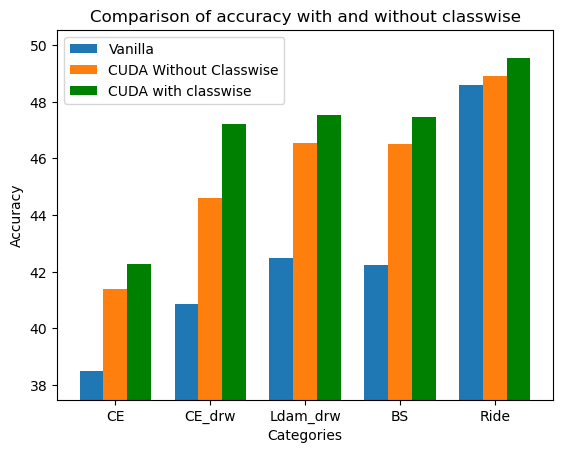

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['CE', 'CE_drw', 'Ldam_drw', 'BS', 'Ride']
vanilla = [38.49, 40.86, 42.48, 42.24, 48.6]
without_classwise = [41.38, 44.61, 46.55, 46.49, 48.92]
with_classwise = [42.27, 47.23, 47.52, 47.47, 49.53]

# Setting the positions for the bars
x = np.arange(len(categories))  
width = 0.25  # the width of the bars

# Creating the figure and the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width, vanilla, width, label='Vanilla')
bars2 = ax.bar(x, without_classwise, width, label='CUDA Without Classwise')
bars3 = ax.bar(x + width, with_classwise, width, label='CUDA with classwise',color='green')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of accuracy with and without classwise')
ax.set_ylim(min(min(vanilla), min(without_classwise), min(with_classwise)) - 1, max(max(vanilla), max(without_classwise), max(with_classwise)) + 1)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.show()


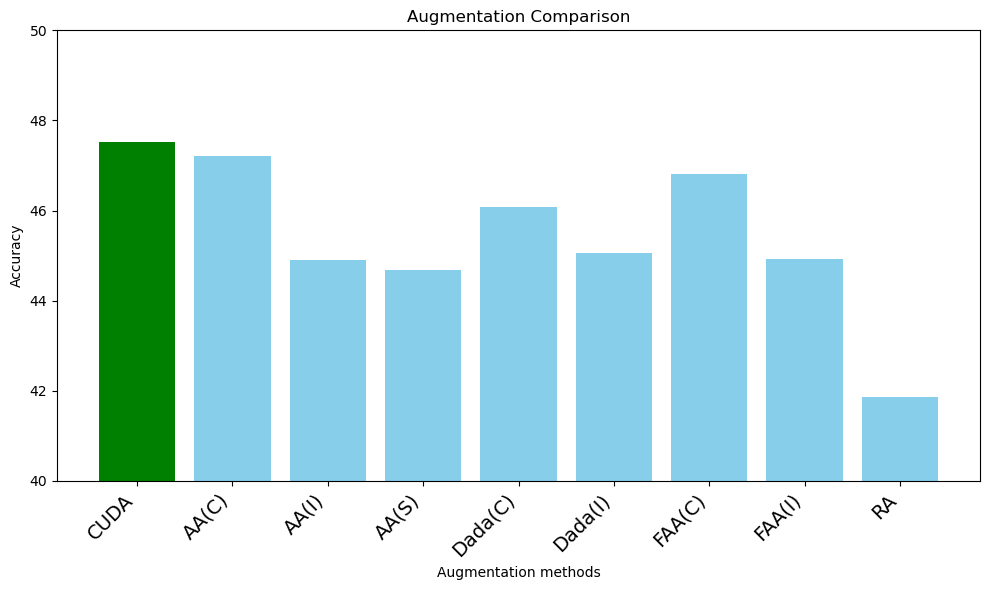

In [13]:
import matplotlib.pyplot as plt

# Data
categories = ['CUDA', 'AA(C)', 'AA(I)', 'AA(S)', 'Dada(C)', 'Dada(I)', 'FAA(C)', 'FAA(I)', 'RA']
values = [47.52, 47.2, 44.9, 44.67, 46.08, 45.05, 46.81, 44.92, 41.87]

# Plotting
plt.figure(figsize=(10, 6))

# Set y-limit
plt.ylim(40, 50)

# Plot all categories
for i, category in enumerate(categories):
    if 'CUDA' in category:
        plt.bar(category, values[i], color='green')
    else:
        plt.bar(category, values[i], color='skyblue')

plt.title('Augmentation Comparison')
plt.xlabel('Augmentation methods')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right', fontsize=14)

plt.tight_layout()

# Show plot
plt.show()



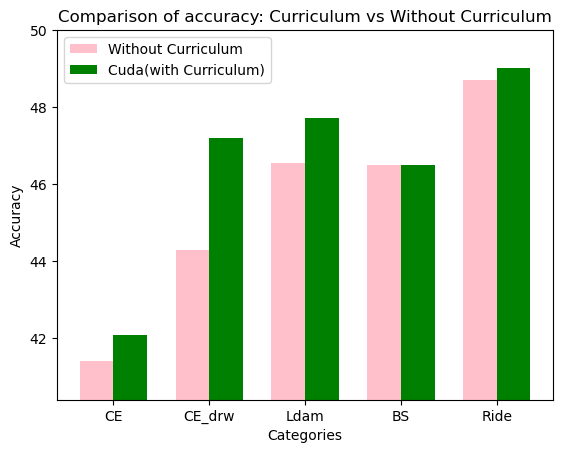

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['CE', 'CE_drw', 'Ldam', 'BS', 'Ride']
curriculum = [42.07, 47.2, 47.73, 46.49, 49.01]
without_curriculum = [41.4, 44.3, 46.56, 46.5, 48.72]

# Setting the positions for the bars
x = np.arange(len(categories))  
width = 0.35  # the width of the bars

# Creating the figure and the bars
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, without_curriculum, width, label='Without Curriculum', color="pink")
bars2 = ax.bar(x + width/2, curriculum, width, label='Cuda(with Curriculum)', color="green")
# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Categories')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of accuracy: Curriculum vs Without Curriculum')
ax.set_xticks(x)
ax.set_xticklabels(categories)

ax.set_ylim(min(min(curriculum), min(without_curriculum)) - 1, max(max(curriculum), max(without_curriculum)) + 1)

ax.legend()

# Display the plot
plt.show()


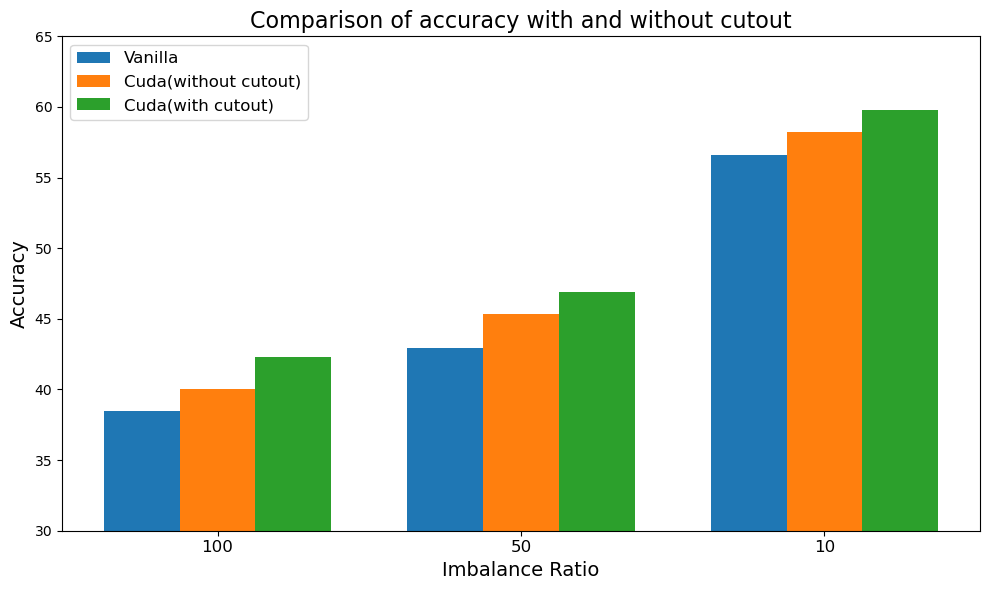

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['100', '50', '10']
vanilla = [38.49, 42.92, 56.61]
cuda_without_cutout = [40.02, 45.36, 58.21]
cuda_with_cutout = [42.27, 46.91, 59.79]

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bars
bar1 = ax.bar(x - width, vanilla, width, label='Vanilla')
bar2 = ax.bar(x, cuda_without_cutout, width, label='Cuda(without cutout)')
bar3 = ax.bar(x + width, cuda_with_cutout, width, label='Cuda(with cutout)')

# Adding labels, title, and legend
ax.set_xlabel('Imbalance Ratio', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Comparison of accuracy with and without cutout', fontsize=16)
ax.set_xticks(x)
ax.set_ylim(30, 65)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
0.93 1.23 -1.46 6.37 5.68 3.93 
 